In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1. Load data
# ---------------------------------------------------
apps = pd.read_csv("data/appearances.csv")
games = pd.read_csv("data/games.csv")
vals  = pd.read_csv("data/player_valuations.csv")

# Ensure date columns are datetime
games["date"] = pd.to_datetime(games["date"])
vals["date"]  = pd.to_datetime(vals["date"])

# Some versions of appearances already have 'date'; we’ll trust games.csv for match date
if "date" in apps.columns:
    apps = apps.drop(columns=["date"])

# ---------------------------------------------------
# 2. Build a universal per-game score in appearances
# ---------------------------------------------------
for col in ["goals", "assists", "yellow_cards", "red_cards", "minutes_played"]:
    if col not in apps.columns:
        # If some column is missing in your local CSV, just create as zeros
        apps[col] = 0

apps[["goals", "assists", "yellow_cards", "red_cards", "minutes_played"]] = (
    apps[["goals", "assists", "yellow_cards", "red_cards", "minutes_played"]]
    .fillna(0)
)

# Avoid division by zero
mp = apps["minutes_played"].clip(lower=1)

goals_per90   = apps["goals"]   * 90.0 / mp
assists_per90 = apps["assists"] * 90.0 / mp
cards_per90   = (apps["yellow_cards"] + 3 * apps["red_cards"]) * 90.0 / mp

# Downweight very short cameos (< 30 minutes)
short_factor = (apps["minutes_played"] / 30.0).clip(upper=1.0)

raw_score = 4.0 * goals_per90 + 3.0 * assists_per90 - cards_per90
apps["universal_score"] = raw_score * short_factor

# ---------------------------------------------------
# 3. Merge appearances with games to attach match dates
# ---------------------------------------------------
apps = apps.merge(
    games[["game_id", "date"]],
    on="game_id",
    how="left"
)

apps = apps.dropna(subset=["date"])  # keep only appearances with a known match date
apps = apps.sort_values(["player_id", "date"])

# ---------------------------------------------------
# 4. Helper: z-score function
# ---------------------------------------------------
def zscore(series: pd.Series) -> pd.Series:
    mean = series.mean()
    std = series.std()
    if std == 0 or np.isnan(std):
        return series * 0  # all zeros
    return (series - mean) / std

# ---------------------------------------------------
# 5. Main plotting function
# ---------------------------------------------------
def plot_player_score_vs_value(
    player_id: int,
    title_suffix: str = ""
):
    """
    For a given player_id, plot standardized universal_score and market_value_in_eur
    over time with dual y-axes.
    """
    # ---- Filter appearances for this player ----
    apps_p = apps[apps["player_id"] == player_id].copy()
    if apps_p.empty:
        raise ValueError(f"No appearances found for player_id={player_id}")

    # Keep only rows with a computed score
    apps_p = apps_p.dropna(subset=["universal_score"])
    apps_p = apps_p.sort_values("date")

    # ---- Filter valuations for this player ----
    vals_p = vals[vals["player_id"] == player_id].copy()
    if vals_p.empty:
        raise ValueError(f"No valuations found for player_id={player_id}")

    vals_p = vals_p.dropna(subset=["market_value_in_eur"])
    vals_p = vals_p.sort_values("date")[["date", "market_value_in_eur"]]

    # ---- Align each game with the latest valuation <= game date ----
    merged = pd.merge_asof(
        apps_p.sort_values("date"),
        vals_p,
        on="date",
        direction="backward"
    )

    # Drop games that are earlier than the first valuation
    merged = merged.dropna(subset=["market_value_in_eur"])
    if merged.empty:
        raise ValueError(
            f"No overlapping dates between appearances and valuations for player_id={player_id}"
        )

    # ---- Standardize both series ----
    merged["score_z"] = zscore(merged["universal_score"])
    merged["mv_z"]    = zscore(merged["market_value_in_eur"])

    # ---------------------------------------------------
    # 6. Plot: time on x, dual y-axes
    # ---------------------------------------------------
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Left y-axis: standardized universal score per game
    l1 = ax1.plot(
        merged["date"],
        merged["score_z"],
        marker="o",
        linestyle="-",
        label="Std. Universal Score (per game)"
    )
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Standardized Universal Score")
    ax1.grid(True, which="both", axis="both", alpha=0.3)

    # Right y-axis: standardized market value
    ax2 = ax1.twinx()
    l2 = ax2.plot(
        merged["date"],
        merged["mv_z"],
        marker="s",
        linestyle="--",
        label="Std. Market Value"
    )
    ax2.set_ylabel("Standardized Market Value")

    # Legend combining both
    lines = l1 + l2
    labels = [ln.get_label() for ln in lines]
    ax1.legend(lines, labels, loc="best")

    plt.title(f"Player {player_id}: Universal Score vs Market Value (Standardized) {title_suffix}")
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------
# 7. Example usage
# ---------------------------------------------------
# Replace 10 with any player_id you care about
# plot_player_score_vs_value(player_id=10)


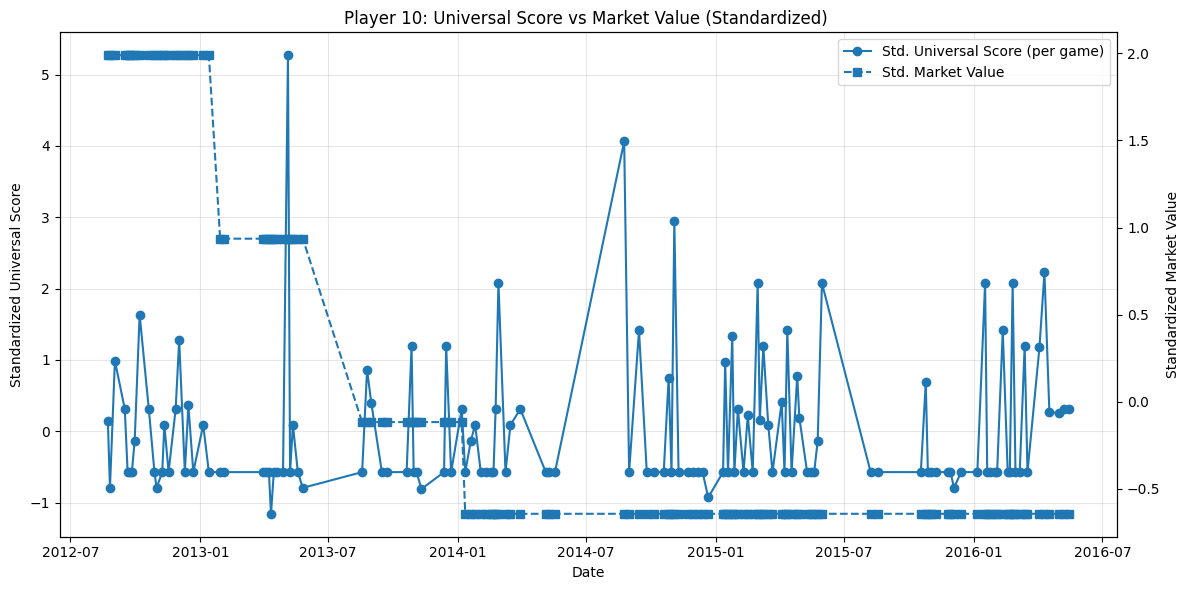

In [7]:
plot_player_score_vs_value(player_id=10)

In [16]:
import pandas as pd
import numpy as np

# ---------------------------------------------------
# 1. Load data
# ---------------------------------------------------
apps    = pd.read_csv("data/appearances.csv")
games   = pd.read_csv("data/games.csv")
vals    = pd.read_csv("data/player_valuations.csv")
players = pd.read_csv("data/players.csv")



# Ensure date columns are datetime
games["date"] = pd.to_datetime(games["date"])
vals["date"]  = pd.to_datetime(vals["date"])

# If appearances already has a date column, drop it and trust games.csv
if "date" in apps.columns:
    apps = apps.drop(columns=["date"])

# ---------------------------------------------------
# 2. Build universal_score in appearances
# ---------------------------------------------------
for col in ["goals", "assists", "yellow_cards", "red_cards", "minutes_played"]:
    if col not in apps.columns:
        apps[col] = 0

apps[["goals", "assists", "yellow_cards", "red_cards", "minutes_played"]] = (
    apps[["goals", "assists", "yellow_cards", "red_cards", "minutes_played"]]
    .fillna(0)
)

mp = apps["minutes_played"].clip(lower=1)  # avoid div by 0

goals_per90   = apps["goals"]   * 90.0 / mp
assists_per90 = apps["assists"] * 90.0 / mp
cards_per90   = (apps["yellow_cards"] + 3 * apps["red_cards"]) * 90.0 / mp

# Downweight very short cameos (< 30 minutes)
short_factor = (apps["minutes_played"] / 30.0).clip(upper=1.0)

raw_score = 4.0 * goals_per90 + 3.0 * assists_per90 - cards_per90
apps["universal_score"] = raw_score * short_factor

# After apps["universal_score"] is already computed

s = apps["universal_score"]
u_min = s.min()
u_max = s.max()

if u_max == u_min:
    # Degenerate case: all games same score
    apps["universal_score_100"] = 50.0
else:
    apps["universal_score_100"] = (s - u_min) / (u_max - u_min) * 100.0


# ---------------------------------------------------
# 3. Attach match date from games
# ---------------------------------------------------
apps = apps.merge(
    games[["game_id", "date"]],
    on="game_id",
    how="left"
)

apps = apps.dropna(subset=["date"])
apps["date"] = pd.to_datetime(apps["date"])

# We only need these columns going forward
apps = apps[["player_id", "game_id", "date", "universal_score_100"]]

# ---------------------------------------------------
# 4. Prepare valuations (per player over time)
# ---------------------------------------------------
vals = vals.dropna(subset=["date", "market_value_in_eur"])
vals["date"] = pd.to_datetime(vals["date"])
vals = vals[["player_id", "date", "market_value_in_eur"]]

# ---------------------------------------------------
# 5. Per-player merge_asof to attach latest valuation <= game date
# ---------------------------------------------------
merged_list = []

apps_sorted = apps.sort_values(["player_id", "date"])
vals_sorted = vals.sort_values(["player_id", "date"])

for pid, apps_p in apps_sorted.groupby("player_id"):
    vals_p = vals_sorted[vals_sorted["player_id"] == pid]

    if vals_p.empty:
        # No valuation history for this player
        continue

    apps_p = apps_p.sort_values("date")
    vals_p = vals_p.sort_values("date")

    # For this player, align each game with last known valuation
    m = pd.merge_asof(
        left=apps_p,
        right=vals_p[["date", "market_value_in_eur"]],
        on="date",
        direction="backward"
    )

    merged_list.append(m)

# Concatenate all players
merged = pd.concat(merged_list, ignore_index=True)

# Drop appearances earlier than first valuation
merged = merged.dropna(subset=["market_value_in_eur"])

# ---------------------------------------------------
# 6. Attach player_name at the end (no slicing before it exists)
# ---------------------------------------------------
# Build a clean player_name column in players
if "name" in players.columns:
    players["player_name"] = players["name"]
elif {"first_name", "last_name"}.issubset(players.columns):
    players["player_name"] = (
        players["first_name"].fillna("") + " " + players["last_name"].fillna("")
    ).str.strip()
else:
    # Fallback: use whatever ID as a string
    players["player_name"] = players["player_id"].astype(str)

players_name = players[["player_id", "player_name"]].drop_duplicates()

merged = merged.merge(players_name, on="player_id", how="left")

# ---------------------------------------------------
# 7. Build final dataframe + save to CSV
# ---------------------------------------------------
output_df = merged[[
    "player_id",
    "player_name",
    "date",
    "universal_score_100",
    "market_value_in_eur"
]].rename(columns={
    "date": "time",
    "market_value_in_eur": "market_value"
})

output_df.to_csv("player_game_scores_and_values.csv", index=False)

print(output_df.head())
print("Saved to player_game_scores_and_values.csv")


   player_id     player_name       time  universal_score_100  market_value
0         10  Miroslav Klose 2012-08-23            24.211130     6000000.0
1         10  Miroslav Klose 2012-08-26            17.460317     6000000.0
2         10  Miroslav Klose 2012-09-02            30.283574     6000000.0
3         10  Miroslav Klose 2012-09-16            25.396825     6000000.0
4         10  Miroslav Klose 2012-09-20            19.047619     6000000.0
Saved to player_game_scores_and_values.csv


np.float64(100.0)

In [9]:
print(apps[["player_id","date"]].head())
print(vals[["player_id","date"]].head())


   player_id       date
0         10 2012-08-23
1         10 2012-08-26
2         10 2012-09-02
3         10 2012-09-16
4         10 2012-09-20
   player_id       date
0         10 2004-10-04
1         10 2005-01-07
2         10 2005-05-05
3         10 2005-09-30
4         10 2006-01-09
